In [56]:
from datetime import date, datetime, timedelta, time
import os
import pytz
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

In [2]:
%cd desktop/metrics-mvp/models

C:\Users\jose\desktop\metrics-mvp\models


In [35]:
%run arrival_history.py

ImportError: cannot import name 'nextbus' from '__main__' (C:\Users\jose\desktop\metrics-mvp\models\arrival_history.py)

In [5]:
%run nextbus.py

In [6]:
%run eclipses.py

In [7]:
%run util.py

In [8]:
test = get_by_date('sf-muni', '12', date(year = 2019, month = 2, day = 2))

In [9]:
testdf = test.get_data_frame(stop_id = '4970')

In [10]:
testdf.head()

,VID,TIME,SID,DID
0,8857,1549117320,4970,12___O_F00
1,8171,1549118536,4970,12___O_F00
2,8629,1549119647,4970,12___O_F00
3,8443,1549120908,4970,12___O_F00
4,8867,1549122109,4970,12___O_F00


In [11]:
# assumes we have a df from one route, one stop, one direction
def get_wait_times(df: pd.DataFrame, date: str, start_time: str, end_time: str):
    # for each arrival time, rounding down to the nearest minute gives us the
    # corresponding minute for which that arrival is first arrival
    waits = df['TIME'].copy(deep = True)
    waits = pd.DataFrame({"ARRIVAL" : waits,
                          "TIME_FLOOR" : waits - (waits % 60)})
    
    # get the minute range in timestamp form
    start_timestamp = datetime.strptime(f"{date} {start_time} -0800", "%Y-%m-%d %H:%M %z").timestamp()
    end_timestamp = datetime.strptime(f"{date} {start_time} -0800", "%Y-%m-%d %H:%M %z").timestamp()
    # account for end_time being 12-3 AM of the next day
    if end_time[0:2] in ["00", "01", "02", "03"]:
        end_timestamp += 86400
        
    minutes_range = [start_timestamp + (60 * i) for i in range(int((end_timestamp - start_timestamp)/60))]
    
    # the remaining first arrivals can be obtained by joining the existing waits to a df
    # containing the rest of the timestamps and backfilling
    all_waits = pd.DataFrame({'TIME' : minutes_range}).join(waits.set_index('TIME_FLOOR'), on = 'TIME', how = 'outer')
    all_waits['ARRIVAL'] = all_waits['ARRIVAL'].fillna(method = 'bfill')
    
    # return the wait times in seconds
    return all_waits['ARRIVAL'] - all_waits['TIME']

In [12]:
waits = get_wait_times(testdf, "2019-02-02", "03:00", "02:59")

In [13]:
waits.mean()/60

28.02419268748332

In [18]:
def get_trip_times(dates: list, agency: str, tz: pytz.timezone, start_time_str: str, end_time_str: str, 
                   route_id: str, s1: str, s2: str):
    completed_trips_arr = []

    for d in dates:
        date_str = str(d)

        history = get_by_date(agency, route_id, d)

        s1_df = history.get_data_frame(stop_id=s1, tz=tz, start_time_str=start_time_str, end_time_str=end_time_str)

        if s1_df.empty:
            print(f"no arrival times found for stop {s1} on {date_str}")
            continue

        s1_df = s1_df.sort_values('TIME', axis=0)

        # in case we don't see the vehicle arrive at s2 in the current run,
        # look at the next time the same vehicle arrives back at s1, only look at s2 arrivals before that time
        def find_dest_arrival_time(row):
            next_return_time = history.find_next_arrival_time(s1, row.VID, row.TIME)
            return history.find_next_arrival_time(s2, row.VID, row.TIME, next_return_time)

        s1_df['dest_arrival_time'] = s1_df.apply(find_dest_arrival_time, axis=1)
        s1_df['trip_min'] = (s1_df.dest_arrival_time - s1_df.TIME)/60
        s1_df['dest_arrival_time_str'] = s1_df['dest_arrival_time'].apply(lambda timestamp: datetime.fromtimestamp(timestamp, tz).time() if not np.isnan(timestamp) else None)

        for index, row in s1_df.iterrows():
            print(f"s1_t={row.DATE_STR} {row.TIME_STR} ({row.TIME}) s2_t={row.dest_arrival_time_str} ({row.dest_arrival_time}) vid:{row.VID} trip_minutes:{round(row.trip_min, 1)}")

        completed_trips_arr.append(s1_df.trip_min[s1_df.trip_min.notnull()])
        
    return pd.concat(completed_trips_arr)

In [19]:
get_trip_times(get_dates_in_range("2019-02-02", "2019-02-02"), "sf-muni", pytz.timezone("US/Pacific"), "03:00", "23:59", "12", "4970", "4973")

s1_t=2019-02-02 06:22:00 (1549117320) s2_t=06:25:00 (1549117500) vid:8857 trip_minutes:3.0
s1_t=2019-02-02 06:42:16 (1549118536) s2_t=06:45:16 (1549118716) vid:8171 trip_minutes:3.0
s1_t=2019-02-02 07:00:47 (1549119647) s2_t=07:02:47 (1549119767) vid:8629 trip_minutes:2.0
s1_t=2019-02-02 07:21:48 (1549120908) s2_t=07:24:48 (1549121088) vid:8443 trip_minutes:3.0
s1_t=2019-02-02 07:41:49 (1549122109) s2_t=07:44:49 (1549122289) vid:8867 trip_minutes:3.0
s1_t=2019-02-02 08:01:05 (1549123265) s2_t=08:04:05 (1549123445) vid:8857 trip_minutes:3.0
s1_t=2019-02-02 08:25:36 (1549124736) s2_t=08:28:51 (1549124931) vid:8171 trip_minutes:3.2
s1_t=2019-02-02 08:40:52 (1549125652) s2_t=08:43:37 (1549125817) vid:8629 trip_minutes:2.8
s1_t=2019-02-02 09:08:38 (1549127318) s2_t=09:11:38 (1549127498) vid:8652 trip_minutes:3.0
s1_t=2019-02-02 09:31:39 (1549128699) s2_t=09:34:40 (1549128880) vid:8443 trip_minutes:3.0
s1_t=2019-02-02 09:44:55 (1549129495) s2_t=09:46:55 (1549129615) vid:8867 trip_minutes:2.0

0     3.000000
1     3.000000
2     2.000000
3     3.000000
4     3.000000
5     3.000000
6     3.250000
7     2.750000
8     3.000000
9     3.016667
10    2.000000
11    2.000000
12    5.000000
13    2.000000
14    3.000000
15    4.250000
16    3.000000
17    4.000000
18    3.250000
19    2.000000
20    3.250000
21    3.000000
22    4.000000
23    2.750000
24    3.000000
25    4.766667
26    3.000000
27    3.016667
28    3.000000
29    3.250000
30    4.000000
31    3.250000
32    3.000000
33    3.250000
34    4.766667
35    3.000000
36    4.016667
37    2.750000
38    2.750000
39    2.000000
40    1.750000
41    2.250000
42    2.000000
43    2.250000
44    3.016667
Name: trip_min, dtype: float64

In [5]:
all_files = []

In [15]:
os.listdir("..\\data\\timetables")

['route_10_timetables_data.csv',
 'route_12_timetables_data.csv',
 'route_14R_timetables_data.csv',
 'route_14X_timetables_data.csv',
 'route_14_timetables_data.csv',
 'route_18_timetables_data.csv',
 'route_19_timetables_data.csv',
 'route_1AX_timetables_data.csv',
 'route_1BX_timetables_data.csv',
 'route_1_timetables_data.csv',
 'route_21_timetables_data.csv',
 'route_22_timetables_data.csv',
 'route_23_timetables_data.csv',
 'route_24_timetables_data.csv',
 'route_25_timetables_data.csv',
 'route_27_timetables_data.csv',
 'route_28R_timetables_data.csv',
 'route_28_timetables_data.csv',
 'route_29_timetables_data.csv',
 'route_2_timetables_data.csv',
 'route_30X_timetables_data.csv',
 'route_30_timetables_data.csv',
 'route_31AX_timetables_data.csv',
 'route_31BX_timetables_data.csv',
 'route_31_timetables_data.csv',
 'route_33_timetables_data.csv',
 'route_35_timetables_data.csv',
 'route_36_timetables_data.csv',
 'route_37_timetables_data.csv',
 'route_38AX_timetables_data.csv',


In [16]:
filepaths = [f"..\\data\\timetables\\{filename}" for filename in os.listdir("..\\data\\timetables")]

In [17]:
for fp in filepaths:
    all_files.append(pd.read_csv(fp))

In [30]:
all_timetables = pd.concat(all_files)

In [31]:
all_timetables.head()

,ROUTE,direction,timetable,trip_id,stop_id,TIME
0,10,IB,Saturday,8528062,17518,2019-03-21 06:35:00
1,10,IB,Saturday,8528062,14350,2019-03-21 06:48:00
2,10,IB,Saturday,8528062,16700,2019-03-21 06:51:00
3,10,IB,Saturday,8528062,16695,2019-03-21 06:53:00
4,10,IB,Saturday,8528062,17549,2019-03-21 06:56:00


In [33]:
all_timetables["TIME"] = all_timetables["TIME"].apply(lambda x: datetime.strptime(f"{x} -0800", "%Y-%m-%d %H:%M:%S %z").time())

In [38]:
all_timetables["total_seconds"] = all_timetables["TIME"].apply(lambda x: x.second/3600 + x.minute/60 + x.hour)

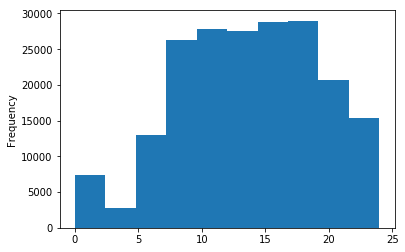

In [39]:
all_timetables["total_seconds"].plot.hist()

In [45]:
all_timetables[(all_timetables["total_seconds"] > 2.5) & (all_timetables["total_seconds"] < 5)].ROUTE.unique()

array([14, 1, 22, 24, 25, 30, 31, 38, 41, 44, 48, 5, 714, 8, 90, 91, 9,
       'F', 'J', 'KT', 'L-OWL', 'L', 'M', 'N-OWL', 'N', 'T-OWL', 'TBUS'],
      dtype=object)

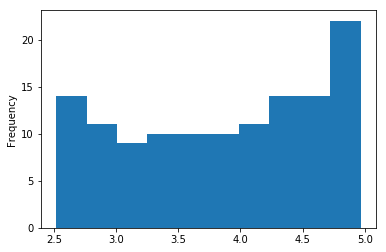

In [55]:
all_timetables[(all_timetables["ROUTE"] == 14) & (all_timetables["timetable"] == "Weekday") & (all_timetables["total_seconds"] > 2.5) & (all_timetables["total_seconds"] < 5)].total_seconds.plot.hist()

In [57]:
all_timetables["hour"] = all_timetables["total_seconds"].apply(math.floor)

In [58]:
all_timetables.head()

,ROUTE,direction,timetable,trip_id,stop_id,TIME,total_seconds,hour
0,10,IB,Saturday,8528062,17518,06:35:00,6.583333,6
1,10,IB,Saturday,8528062,14350,06:48:00,6.800000,6
2,10,IB,Saturday,8528062,16700,06:51:00,6.850000,6
3,10,IB,Saturday,8528062,16695,06:53:00,6.883333,6
4,10,IB,Saturday,8528062,17549,06:56:00,6.933333,6


In [66]:
timetable_counts = all_timetables[["ROUTE", "direction", "timetable", "stop_id", "hour"]].pivot_table(index = ["ROUTE", "direction", "timetable", "stop_id"], columns = "hour", aggfunc = len).fillna(0)

In [68]:
timetable_counts

hour                                0    1    2    3    4    5    6     7   \
ROUTE direction timetable stop_id                                            
1     IB        Saturday  13825    3.0  4.0  3.0  0.0  1.0  2.0  4.0   5.0   
                          13893    3.0  4.0  3.0  0.0  0.0  3.0  4.0   5.0   
                          14015    3.0  3.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14026    3.0  2.0  0.0  0.0  0.0  3.0  3.0   5.0   
                          14027    4.0  2.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14028    3.0  3.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14277    4.0  3.0  2.0  0.0  1.0  3.0  4.0   5.0   
                          16296    3.0  2.0  0.0  0.0  0.0  3.0  4.0   4.0   
                Sunday    13825    3.0  4.0  3.0  0.0  1.0  2.0  4.0   5.0   
                          13893    3.0  4.0  3.0  0.0  0.0  3.0  4.0   5.0   
                          14015    3.0  3.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14026    3.0  2.0  0.0  0.0  0.0  3.0  3.0   5.0   
                          14027    4.0  2.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14028    3.0  3.0  0.0  0.0  0.0  2.0  4.0   4.0   
                          14277    4.0  3.0  2.0  0.0  1.0  3.0  4.0   5.0   
                          16296    3.0  2.0  0.0  0.0  0.0  3.0  4.0   4.0   
                Weekday   13825    3.0  3.0  0.0  0.0  1.0  3.0  9.0   8.0   
                          13893    3.0  3.0  0.0  0.0  1.0  3.0  7.0  16.0   
                          14015    3.0  0.0  0.0  0.0  0.0  2.0  6.0  12.0   
                          14026    3.0  0.0  0.0  0.0  0.0  3.0  6.0  15.0   
                          14027    3.0  0.0  0.0  0.0  0.0  3.0  6.0  13.0   
                          14028    3.0  0.0  0.0  0.0  0.0  2.0  6.0  13.0   
                          14277    4.0  2.0  0.0  0.0  1.0  4.0  9.0   9.0   
                          16296    2.0  0.0  0.0  0.0  1.0  2.0  7.0  16.0   
      OB        Saturday  13824    3.0  3.0  2.0  0.0  1.0  4.0  4.0   6.0   
                          13892    4.0  3.0  1.0  0.0  2.0  3.0  5.0   6.0   
                          14015    3.0  3.0  1.0  0.0  0.0  2.0  3.0   4.0   
                          14277    3.0  3.0  2.0  0.0  1.0  4.0  4.0   5.0   
                          16295    3.0  3.0  1.0  0.0  0.0  1.0  3.0   4.0   
                          16311    3.0  3.0  1.0  0.0  0.0  1.0  3.0   4.0   
...                                ...  ...  ...  ...  ...  ...  ...   ...   
TBUS  IB        Saturday  13115    4.0  3.0  0.0  0.0  0.0  0.0  2.0   3.0   
                          13123    4.0  2.0  0.0  0.0  0.0  0.0  2.0   4.0   
                          16475    4.0  1.0  0.0  0.0  0.0  0.0  4.0   4.0   
                          16847    4.0  3.0  0.0  0.0  0.0  0.0  1.0   4.0   
                          17366    4.0  1.0  0.0  0.0  0.0  0.0  3.0   4.0   
                Sunday    13115    4.0  3.0  0.0  0.0  0.0  0.0  2.0   3.0   
                          13123    4.0  2.0  0.0  0.0  0.0  0.0  2.0   4.0   
                          16475    4.0  1.0  0.0  0.0  0.0  0.0  4.0   4.0   
                          16847    4.0  3.0  0.0  0.0  0.0  0.0  1.0   4.0   
                          17366    4.0  1.0  0.0  0.0  0.0  0.0  3.0   4.0   
                Weekday   13115    6.0  3.0  0.0  0.0  0.0  2.0  3.0   6.0   
                          13123    6.0  2.0  0.0  0.0  0.0  2.0  4.0   7.0   
                          16475    6.0  0.0  0.0  0.0  0.0  4.0  5.0   8.0   
                          16847    6.0  4.0  0.0  0.0  0.0  1.0  4.0   5.0   
                          17366    6.0  1.0  0.0  0.0  0.0  3.0  4.0   8.0   
      OB        Saturday  13116    2.0  0.0  0.0  0.0  0.0  0.0  2.0   5.0   
                          13122    2.0  0.0  0.0  0.0  0.0  0.0  1.0   5.0   
                          13793    1.0  0.0  0.0  0.0  0.0  0.0  2.0   6.0   
                      

In [6]:
test['timetable'].unique()

array(['Saturday', 'Sunday', 'Weekday'], dtype=object)

In [7]:
stop_ids = list(test['stop_id'].unique())

In [8]:
def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [10]:
def get_timetable(route_id: str, stop_id: int, d: date):
    path = f"../data/timetables/route_{route_id}_timetables_data.csv"
    df = pd.read_csv(path)
    df['TIME'] = df['TIME'].apply(lambda x: datetime.strptime(f"{x} -0800", "%Y-%m-%d %H:%M:%S %z"))
    day = d.weekday()
    timetable_type = "Weekday" if day < 5 else ("Saturday" if day == 5 else "Sunday")
    
    return df[(df['stop_id'] == stop_id) & (df['timetable'] == timetable_type)]

In [11]:
stop_ids

[13476,
 14677,
 14664,
 14658,
 17549,
 16333,
 15852,
 17941,
 15853,
 16327,
 13011,
 14968,
 14665,
 17312]

In [12]:
timetables = []

for id in stop_ids:
    timetables.append(get_timetable("12", id, date(2019, 2, 2)))

In [13]:
test_timetable = get_timetable("12", 13476, date(2019, 2, 2))

In [14]:
test_timetable.head()

,ROUTE,direction,timetable,trip_id,stop_id,TIME
0,12,IB,Saturday,8528519,13476,2019-03-21 05:30:00-08:00
8,12,IB,Saturday,8528520,13476,2019-03-21 05:50:00-08:00
16,12,IB,Saturday,8528521,13476,2019-03-21 06:10:00-08:00
24,12,IB,Saturday,8528522,13476,2019-03-21 06:27:00-08:00
32,12,IB,Saturday,8528523,13476,2019-03-21 06:47:00-08:00


In [15]:
test_timetable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 1727
Data columns (total 6 columns):
ROUTE        100 non-null int64
direction    100 non-null object
timetable    100 non-null object
trip_id      100 non-null int64
stop_id      100 non-null int64
TIME         100 non-null datetime64[ns, UTC-08:00]
dtypes: datetime64[ns, UTC-08:00](1), int64(3), object(2)
memory usage: 5.5+ KB


In [20]:
test_timetable['TIME'].max().time() > time(23, 35)

True